# U-net MODEL for liver segmentation from CT images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [3]:
!pip install pydicom SimpleITK tensorboardcolab albumentations scikit-image medpy tqdm

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Import dependecies and setup main directory to google drive directory 

In [4]:
import os
import random
import pydicom
import numpy as np
import cv2
from tqdm import tqdm
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pickle
from skimage import feature
import tables
from functools import partial
from albumentations import (
    Compose, HorizontalFlip, VerticalFlip, ShiftScaleRotate
)

In [5]:
main_dir = '..'
data_dir = f'{main_dir}/data'
COLUMNS, ROWS = 512, 512

In [ ]:
COLUMNS, ROWS = 512, 512
main_dir = '/content/drive/My Drive/DP - Prototype'
data_dir = f'{main_dir}/data'

## Open HDF file
HDF allow to read file in baches from disc during the training phase instead of reading all data to RAM at once. 

In [6]:
train_file = tables.open_file(f'{main_dir}/CT-train.h5', mode="r")
print(train_file)

../CT-train.h5 (File) ''
Last modif.: 'Sat May  4 17:25:35 2019'
Object Tree: 
/ (RootGroup) ''
/x (CArray(2874, 512, 512), shuffle, blosc(5)) ''
/y (CArray(2874, 512, 512), shuffle, blosc(5)) ''



In [7]:
x_train = train_file.get_node('/x')
y_train = train_file.get_node('/y')

In [8]:
OPEN_MODEL = 'unet-REG-50-CROSSENTROPY-AUGM'

### Plot slices

In [8]:
def plot_slice(x, y):
  counter = 1
  if len(x.shape) > 2:
    length = x.shape[2] + 1
  else:
    length = 2
  
  figure = plt.figure(figsize=(20, 20))
  if len(x.shape) > 2 and x.shape[2] == 2:
    plt.subplot(1, length, counter) 
    plt.imshow(np.nan_to_num(x[:, :, 0]), cmap="bone")
    counter += 1
  
    plt.subplot(1, length, counter) 
    plt.imshow(np.nan_to_num(x[:, :, 1]), cmap="bone")
    counter += 1
    
  else:
    if len(y.shape) > 2:
      plt.subplot(1, length, counter) 
      plt.imshow(np.nan_to_num(x[:, :, 0]), cmap="bone")
      counter += 1
    else:
      plt.subplot(1, length, counter) 
      plt.imshow(np.nan_to_num(x), cmap="bone")
      counter += 1
    
  
  if len(y.shape) > 2:
    plt.subplot(1, length, counter)
    plt.imshow(np.nan_to_num(y[:, :, 0]), cmap="bone")
   
  else:
    plt.subplot(1, length, counter)
    plt.imshow(np.nan_to_num(y), cmap="bone")
  
  plt.show()

In [9]:
slice_n = 5

y = y_train[slice_n]


dt = distance_transform_weight(y)
plt.imshow(dt)
plt.colorbar()
# plot_slice(dt / 255, y_train[slice_n])

NameError: name 'distance_transform_weight' is not defined

#### Image plots


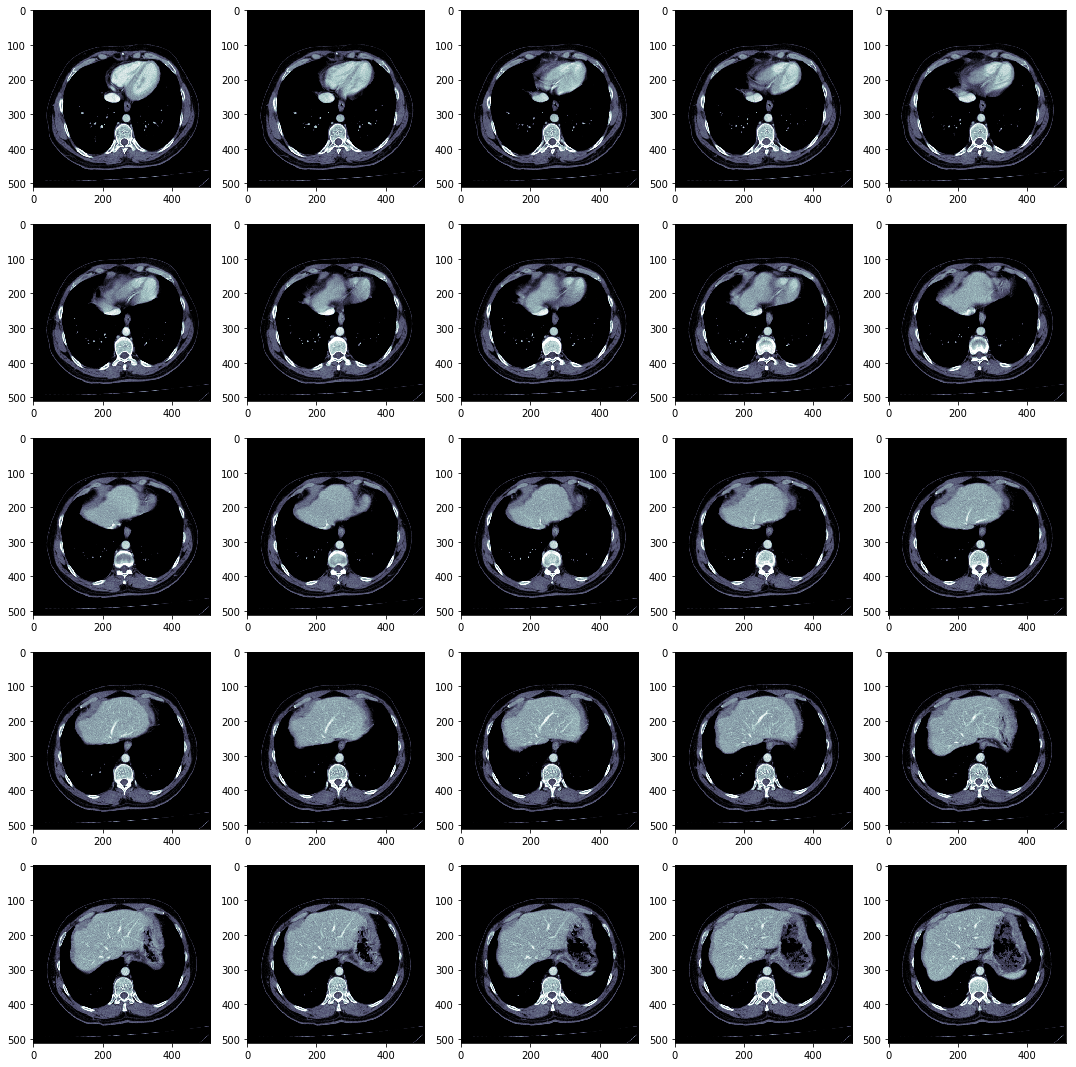

In [10]:
fig = plt.figure(figsize=(15,15))

for num in range(1,26):
    ax = fig.add_subplot(5,5,num)
    plt.imshow(x_train[num].reshape((COLUMNS, ROWS)), cmap="bone")

plt.tight_layout()
plt.show()

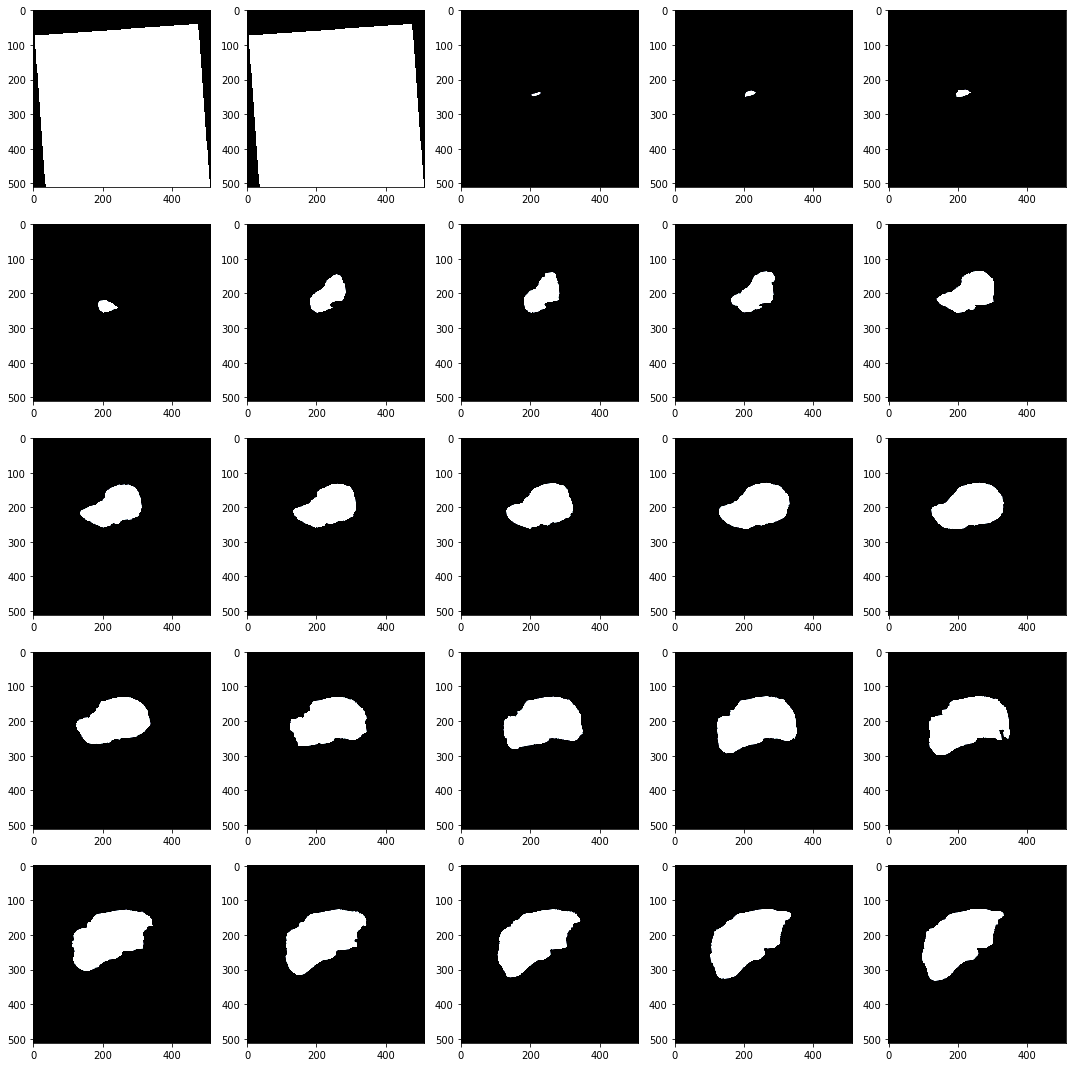

In [11]:
fig = plt.figure(figsize=(15,15))

for num in range(1,26):
    ax = fig.add_subplot(5,5,num)
    plt.imshow(y_train[num].reshape((COLUMNS, ROWS)), cmap="bone")

plt.tight_layout()
plt.show()

## Utils
We define set of helper functions which includes metrics, generator or local binary patterns operation.

In [16]:
import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from distutils.dir_util import copy_tree
from sklearn.metrics import accuracy_score
from functools import partial

print('TF version:', tf.VERSION)
print('TF GPUs:', K.tensorflow_backend._get_available_gpus())

TF version: 1.5.0
TF GPUs: ['/job:localhost/replica:0/task:0/device:GPU:0']


In [17]:
def weighted_binary_crossentropy(y_true, y_pred, weights_input, sample_weight=None):
  return K.mean(K.binary_crossentropy(y_true, y_pred) * weights_input)

In [18]:
smooth = 0.000001
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [19]:
def round_sigmoid(x):
    res = K.sigmoid(x)
    return K.relu()

In [20]:
def get_local_binary_pattern(x):
  res = feature.local_binary_pattern(x.copy(), 8 * 2, 4, 'default')
#   smooth = 0.00000001
#   res -= np.min(res) + smooth
#   res /= np.max(res) + smooth
#   return 1 - res
  print(res.shape, res.dtype)
  return res
  

In [21]:
def distance_transform_weight(x):
    x = 1 - x
    x *= 255
    x = x.astype(np.uint8)
    dt = cv2.distanceTransform(x, cv2.DIST_L2, 3)
    dt = (dt / 255)
    return (dt / (np.max(dt) * 2)) + 1

In [22]:
def generator(X_data, y_data, batch_size, indices, augmentation, LBP=False, weights=True):
    indx = indices
    samples_per_epoch = len(indx)
    number_of_batches = samples_per_epoch / batch_size
    counter = 0

    channels = 1
    if LBP:
      channels = 2

    while 1:
        start = batch_size * counter
        stop = batch_size * (counter + 1)
        indxs = indx[start:stop]
        shape = X_data.shape

        X_batch = np.zeros((batch_size, X_data.shape[1], X_data.shape[2], 1))
        y_batch = np.zeros((batch_size, y_data.shape[1], y_data.shape[2], 1))

        if weights:
          weights_batch = np.zeros((batch_size, y_data.shape[1], y_data.shape[2], 1))

        
        for i, idx in enumerate(indxs):
            if augmentation is not None:
                x = np.nan_to_num(X_data[idx])
                y = np.nan_to_num(y_data[idx])
                aug = augmentation(image=x, mask=y)
                y_batch[i] = aug["mask"].reshape((shape[1], shape[2], 1))

                if weights:
                  weights_batch[i] = distance_transform_weight(aug["mask"])
                  weights_batch[i] = np.nan_to_num(weights_batch[i]).reshape((shape[1], shape[2], 1))
                
                if LBP:
                  lbp = get_local_binary_pattern(aug["image"])
                  X_batch[i, :, :, 0] = np.nan_to_num(lbp)
                else:
                  X_batch[i, :, :] = aug["image"].reshape((shape[1], shape[2], 1))
                  


        counter += 1
        if weights:
          yield [X_batch.astype(np.float64), weights_batch.astype(np.float64)], y_batch.astype(np.float64)
        else:
          yield X_batch.astype(np.float64), y_batch.astype(np.float64)

        # restart counter to yeild data in the next epoch as well
        if counter >= number_of_batches:
            np.random.shuffle(indx)
            counter = 0

#### Split to train and validation set
We are using first 16 patient from the training set as train set and remaining 4 patients as validation set. Split 2302 is the first slice of the patient in validation set. 

In [23]:
with open(f'{main_dir}/patient_slices.pkl', 'rb') as input:
    patient_slices = pickle.load(input)
    print(patient_slices)

[{'id': '1', 'slices': 96}, {'id': '10', 'slices': 110}, {'id': '14', 'slices': 95}, {'id': '16', 'slices': 91}, {'id': '18', 'slices': 111}, {'id': '19', 'slices': 90}, {'id': '2', 'slices': 81}, {'id': '21', 'slices': 257}, {'id': '22', 'slices': 101}, {'id': '23', 'slices': 240}, {'id': '24', 'slices': 123}, {'id': '25', 'slices': 235}, {'id': '26', 'slices': 114}, {'id': '27', 'slices': 242}, {'id': '28', 'slices': 102}, {'id': '29', 'slices': 214}, {'id': '30', 'slices': 266}, {'id': '5', 'slices': 95}, {'id': '6', 'slices': 88}, {'id': '8', 'slices': 123}]


In [24]:
def sum_slices(arr):
  return np.sum(list(map(lambda x: x["slices"], arr)))

In [25]:
## TOTAL 20 patients arond 100 slices per patient 
ALL_SIZE = sum_slices(patient_slices)
print('All slices:', ALL_SIZE)

patients_len = len(patient_slices)
train_split = int(0.7 * patients_len)
val_split = int(0.1 * patients_len)
test_split = int(0.2 * patients_len)

train_patients = patient_slices[:train_split] 
val_patients = patient_slices[train_split:train_split + val_split]
test_patients = patient_slices[train_split + val_split:]

indices = np.arange(ALL_SIZE)

train_size = sum_slices(train_patients)
val_size = sum_slices(val_patients)
test_size = sum_slices(test_patients)

train_ind = indices[:train_size]
eval_ind = indices[train_size:train_size + val_size]
test_ind = indices[train_size + val_size:]

All slices: 2874


In [26]:
print("Train IND (example):", train_ind[:10], ', shape:', train_ind.shape)
print("Validation IND (example):", eval_ind[:10], ', shape:', eval_ind.shape)
print("TEST IND (example):", test_ind[:10], ', shape:', test_ind.shape)

Train IND (example): [0 1 2 3 4 5 6 7 8 9] , shape: (1986,)
Validation IND (example): [1986 1987 1988 1989 1990 1991 1992 1993 1994 1995] , shape: (316,)
TEST IND (example): [2302 2303 2304 2305 2306 2307 2308 2309 2310 2311] , shape: (572,)


##### Test Activation function

In [22]:
x = K.constant(np.array([[0, 0]]))
y = K.constant(np.array([[1, 1]]))
w = K.constant(np.array([[1, 1.0]]))
print(K.get_value(weighted_binary_crossentropy(y, x, w)))

16.118095


In [ ]:
x = np.array([[[0, 0], [1, 0]]])
y = np.array([[[0, 0], [1, 0]]])
K.get_value(K.mean(K.binary_crossentropy(K.constant(x), K.constant(y), None)))

##### Example local binary patterns

In [ ]:
slice_n = 560
x_slice = x_train[slice_n]
x_lbp = get_local_binary_pattern(x_slice)
plot_slice(x_slice, x_lbp)

## Train model

### Data Augmentation - Albumentations

In [27]:
TRAIN_AUGMENT = Compose([
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=8, border_mode=cv2.BORDER_CONSTANT, p=0.8),
])

### Model

Keras implementation of U-net was originaly posted [here](https://github.com/zhixuhao/unet/blob/master/model.py). Code was modified as we were experimenting with number of filters in the network.

In [32]:
def u_net(input_shape, distance_transform=False):

    weighted_loss = '_'

    inputs = Input(input_shape)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same')(inputs)
    conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same')(pool1)
    conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same')(pool2)
    conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
#     conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(pool3)
#     conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same')(conv4)
    drop4 = Dropout(0.5)(conv3)

#     up7 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop4))
#     merge7 = concatenate([conv3,up7], axis = 3)
#     conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(merge7)
#     conv7 = Conv2D(128, 3, activation = 'relu', padding = 'same')(conv7)

    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(drop4))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same')(conv8)

    up9 = Conv2D(32, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(merge9)
    conv9 = Conv2D(32, 3, activation = 'relu', padding = 'same')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    if distance_transform:
      weights_in = Input(input_shape)
      weighted_loss = partial(weighted_binary_crossentropy, weights_input=weights_in)
      model = Model(inputs=[inputs, weights_in], outputs=conv10)
      model.compile(optimizer=Adam(lr=1e-4), loss=weighted_loss, metrics=['accuracy', dice_coef])
    else:
      model = Model(inputs=inputs, outputs=conv10)
      model.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy', dice_coef])
    
    ## model.summary()

    return model, weighted_loss


In [36]:
LBP = False
channels = 1

model, weights_loss = u_net((COLUMNS, ROWS, channels), distance_transform=False)
# model.summary()

DEFAULT_MODEL = 'unet-REG-50-CROSSENTROPY-AUGM-WEIGHTS'

# print('Default model name:', DEFAULT_MODEL)
# name = raw_input()
MODEL = DEFAULT_MODEL
print('Using:', MODEL)

model_checkpoint = ModelCheckpoint(f'{main_dir}/models/checkpoint/{MODEL}(ckpt).hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

epochs = 50
batch_size = 5

train_gen = generator(x_train, y_train, batch_size, train_ind, augmentation=TRAIN_AUGMENT, weights=False)
eval_gen = generator(x_train, y_train, batch_size, eval_ind, augmentation=TRAIN_AUGMENT, weights=False)

# model.fit_generator(x_train, y_train, batch_size=10, epochs=50, validation_data=(x_test, y_test), callbacks=[TensorBoardColabCallback(tbc), model_checkpoint])

history = model.fit_generator(
    generator=train_gen,
    epochs=epochs,
    verbose=1,
    steps_per_epoch=train_ind.shape[0]//batch_size,
    validation_data=eval_gen,
    validation_steps=eval_ind.shape[0]//batch_size,
    callbacks=[model_checkpoint])

# Save model and tensor logs
model.save_weights(f'{main_dir}/models/{MODEL}.hdf5')

Using: unet-REG-50-CROSSENTROPY-AUGM-WEIGHTS
Epoch 1/50
397/397 [==============================] - 375s 944ms/step - loss: 0.1766 - acc: 0.9410 - dice_coef: 0.2267 - val_loss: 0.2035 - val_acc: 0.9481 - val_dice_coef: 0.0359

Epoch 00001: val_loss improved from inf to 0.20350, saving model to ../models/checkpoint/unet-REG-50-CROSSENTROPY-AUGM-WEIGHTS(ckpt).hdf5
Epoch 2/50
397/397 [==============================] - 378s 951ms/step - loss: 0.0970 - acc: 0.9413 - dice_coef: 0.4106 - val_loss: 0.0907 - val_acc: 0.9486 - val_dice_coef: 0.3896

Epoch 00002: val_loss improved from 0.20350 to 0.09069, saving model to ../models/checkpoint/unet-REG-50-CROSSENTROPY-AUGM-WEIGHTS(ckpt).hdf5
Epoch 3/50
397/397 [==============================] - 349s 879ms/step - loss: 0.0854 - acc: 0.9577 - dice_coef: 0.4498 - val_loss: 0.0776 - val_acc: 0.9662 - val_dice_coef: 0.4317

Epoch 00003: val_loss improved from 0.09069 to 0.07762, saving model to ../models/checkpoint/unet-REG-50-CROSSENTROPY-AUGM-WEIGHTS(c

KeyboardInterrupt: 

In [38]:
print(history)

NameError: name 'history' is not defined

### Save training history to file

In [ ]:
with open(f'{main_dir}/logs/{OPEN_MODEL}.history.pkl', 'wb') as output:  # Overwrites any existing file.
        pickle.dump(history.history, output, pickle.HIGHEST_PROTOCOL)

### Load training history from file

In [ ]:
with open(f'{main_dir}/logs/{OPEN_MODEL}.history.pkl', 'rb') as input:
    input_data = pickle.load(input)

In [ ]:
for key, value in input_data.items():
  print(key)

In [ ]:
f = open(f"{toDirectory}/model-logs.txt", "a")
f.write(f"[MODEL] Finished training of the 'unet-ext' model. Epochs: 50, Batch size: 10, ")
f.close()

## Load and Evaluate Model

In [ ]:
train_file = tables.open_file(f'{main_dir}/CT-train-DT.h5', mode="r")
print(train_file)

#### Plot training STATISTICS

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(input_data["dice_coef"])
axs[0].plot(input_data["val_dice_coef"])
axs[0].set_title("Dice Coefficient")
axs[1].plot(input_data["acc"])
axs[1].plot(input_data["val_acc"])
axs[1].set_title("Accuracy")
axs[2].plot(input_data["loss"])
axs[2].plot(input_data["val_loss"])
axs[2].set_title("Binary crossentropy")
fig.suptitle('Training Evaluation')
plt.figlegend(["Training", "Validation"], loc = 'lower center', ncol=5, labelspacing=0. )

### Load Model - predict evaluation data

In [ ]:
model = load_model(f'{main_dir}/models/checkpoint/{OPEN_MODEL}.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'dice_coef': dice_coef})
print()
print(f"Model: {OPEN_MODEL} successfuly loaded.")

In [ ]:
from medpy.metric import dc, ravd, assd

In [ ]:
x_eval, y_eval = x_train[2302:], y_train[2302:] 
prediction = model.predict(x_eval.reshape((-1, ROWS, COLUMNS, 1)))
print(prediction.shape)
print(x_eval.shape)
print(y_eval.shape)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:

smooth = 0.000001
def dice_coef_np(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)


In [ ]:
pred_f = np.round(prediction)
y_eval_f = y_eval

In [ ]:
print('DSC', dice_coef_np(y_eval_f, pred_f))
print('Precison', precision_score(y_eval_f, pred_f))
print('Recall', recall_score(y_eval_f, pred_f))